# 查看标签

In [1]:
import cv2
import cv2 as cv
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector
import mmcv
import numpy as np


# 导入可视化工具包 matplotlib，并让绘制的图像嵌入在 notebook 中
import matplotlib.pyplot as plt
%matplotlib inline

# 定义可视化图像函数，输入图像路径，可视化图像
def show_img_from_path(img_path):
    '''opencv 读入图像，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img = cv2.imread(img_path)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()
    
# 定义可视化图像函数，输入图像 array，可视化图像
def show_img_from_array(img):
    '''输入 array，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

pose_config = 'mmpose/configs/res101_pig.py'
pose_checkpoint = 'mmpose/work_dirs/resnet101_pig/epoch_190.pth'

# initialize pose model
pose_model = init_pose_model(pose_config, pose_checkpoint,device='cuda:0')

load checkpoint from local path: mmpose/work_dirs/resnet101_pig/epoch_190.pth


In [2]:
import math
def angle(v1, v2):
  dx1 = v1[2] - v1[0]
  dy1 = v1[3] - v1[1]
  dx2 = v2[2] - v2[0]
  dy2 = v2[3] - v2[1]
  angle1 = math.atan2(dy1, dx1)
  angle1 = angle1 * 180/math.pi
  # print(angle1)
  angle2 = math.atan2(dy2, dx2)
  angle2 = angle2 * 180/math.pi
  # print(angle2)
  if angle1*angle2 >= 0:
    included_angle = abs(angle1-angle2)
  else:
    included_angle = abs(angle1) + abs(angle2)
  return included_angle

In [3]:
def angle_for_label(points):
    points=np.array(points)
    link=list()
    for i in range(4):
        l=list()
        l.append(points[0][:2])
        l.append(points[i*4+1:i*4+5,:2])
        link.append(l)
        
    angle_points=list()
    for it in link:
        l=list()
        for i in range(3):
            l.append(np.append(it[0],it[1][i]))
            l.append(np.append(it[1][i+1],it[1][i]))
        l.append(np.append(it[1][0],it[1][1]))
        l.append(np.append(it[1][2],it[1][1]))
        l.append(np.append(it[1][1],it[1][2]))
        l.append(np.append(it[1][3],it[1][2]))
        angle_points.append(l)

    angles=list()
    for it in angle_points:
        l=list()
        for i in range(5):
            if 0 in it[i*2+1] or 0 in it[i*2]:
                l.append(-1)
                continue
            l.append(angle(it[i*2],it[i*2+1]))
        angles.append(l)
    
    return angles


In [4]:
skl_dic=pose_model.cfg.dataset_info.skeleton_info
point_dic=pose_model.cfg.dataset_info.keypoint_info

In [5]:
point_dic={v['name']:k for k,v in point_dic.items()}
skl_dic=[v['link'] for k,v in skl_dic.items()]
skl_dic=[(point_dic[i[0]],point_dic[i[1]]) for i in skl_dic]

In [14]:
import json
import pprint
import cv2
# from easydl import clear_output
import time
import os

# 载入训练集标注文件
data = json.load(open('/home/zhenbang/project/openmmlab/low/train.json', 'r'))
imgs_root='/home/zhenbang/project/openmmlab/low/images'
anns=data['annotations']
imgs=data['images']
imgs={i['id']:i['file_name'] for i in imgs}
anns=sorted(anns,key=lambda x:x['image_id'])


In [15]:
i=1
agl=[]
idx=[]
for it in anns:
    img_path=os.path.join(imgs_root,imgs[it['image_id']])
    img=cv2.imread(img_path)

    # h,w,c=img.shape
    # thr=w/4
    # l=int(thr)
    # r=int(w-thr)

    keypoints=it['keypoints']
    # bbox=it['bbox']
    points=[keypoints[i:i+3] for i in range(0,len(keypoints),3)]
    # for it in points:
    #     if it[0]<l or it[0]>r:
    #         it[0]=0
    #         it[1]=0
    #         it[2]=0

    # for skl in skl_dic:
    #     if points[skl[0]][2]==2 and points[skl[1]][2]==2:
    #         cv2.line(img,(points[skl[0]][0],points[skl[0]][1]),(points[skl[1]][0],points[skl[1]][1]),(0,0,255),3)
    # for point in points:
    #     if point[2]==2:
    #         cv2.circle(img,(point[0],point[1]),3,(0,255,0),-1)
    #         # cv2.rectangle(img,(bbox[0],bbox[1]),(bbox[0]+bbox[2],bbox[1]+bbox[3]),(0,0,255),8)
    #         # cv2.rectangle(img,(l,0),(r,h),(0,0,255),8)
    angles=angle_for_label(points)
    agl.append(angles[3])
    # # rrhoof=angles[3][-2]

    # # if rrhoof > 60:
    # #     agl.append(rrhoof)
    # #     idx.append(i)
    # # # plt.ylim(60,260)
    # # plt.plot(idx,agl,color='r',marker='o',linestyle='-.',alpha=0.5)
    # i+=1
    # # plt.show()
    # show_img_from_array(img)
    # cv.imwrite(f'/home/zhenbang/project/openmmlab/weak/after/weak_{i}.jpg',img)

In [ ]:
np.save('bad.npy',agl)

In [16]:
agl=np.array(agl)

In [17]:
bad=agl[:,4]

In [9]:
weak=agl[:,4]

In [13]:
good=agl[:,4]

In [ ]:
good=np.load('good.npy')[:,3][:15]
bad=np.load('bad.npy')[:,3][:15]
weak=np.load('weak.npy')[:,3][:15]

In [ ]:
good_=np.add(0.8*np.load('good.npy')[:,3][:15],np.load('good.npy')[:,4][:15])
bad_=np.add(0.8*np.load('bad.npy')[:,3][:15],np.load('bad.npy')[:,4][:15])
weak_=np.add(0.8*np.load('weak.npy')[:,3][:15],np.load('weak.npy')[:,4][:15])

In [ ]:
index=np.arange(15)

In [ ]:
weak=weak[:-1]

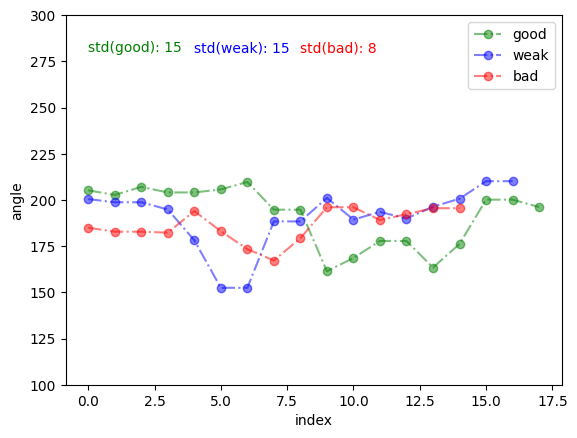

In [25]:
plt.ylim(100,300)
plt.xlabel('index')
plt.ylabel('angle')
plt.plot(np.arange(len(good)),good,color='g',marker='o',linestyle='-.',alpha=0.5,label='good')
plt.text(0, 280, 'std(good): '+str(int(np.std(good))), fontsize=10,color='g')
plt.plot(np.arange(len(weak)),weak,color='b',marker='o',linestyle='-.',alpha=0.5,label='weak')
plt.text(4, 280, 'std(weak): '+str(int(np.std(weak))), fontsize=10,color='b')
plt.plot(np.arange(len(bad)),bad,color='r',marker='o',linestyle='-.',alpha=0.5,label='bad')
plt.text(8, 280, 'std(bad): '+str(int(np.std(bad))), fontsize=10,color='r')
plt.legend()



In [ ]:
def L1(yhat, y):
    loss =np.sum(np.abs(y - yhat))
    return loss

In [ ]:
L1(good,weak)

In [ ]:
L1(good,bad)

In [ ]:
L1(weak,bad)

In [ ]:
L1(good_,weak_)

In [ ]:
L1(good_,bad_)

In [ ]:
it = anns[0]
img_path=os.path.join(imgs_root,imgs[it['image_id']])
img=cv2.imread(img_path)
show_img_from_array(img)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
 
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

 
# Make data.
X = weak[0]
Y = weak1[0]
X, Y = np.meshgrid(X, Y)
Z = np.ones_like(X)
 
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
 
# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
 
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
 
plt.show()